# Text Classification: Natural Language Processing with Disaster Tweets

## Part 1: Downloading the Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
# read csv data using pandas
train_df = pd.read_csv('train.csv',            # make sure to put the file in the working directory
                 sep=',',                      # separater
                 header = 0,                   # the header that indicates the column names is at row 0
                 usecols=['id','keyword', 'location', 'text', 'target'])

## Part 2: Data Preprocessing

We'll first create text_target_train_data and text_target_test_data so that we have versions of the training and testing datasets that only have the text, and not the id, keyword, or location.

In [ ]:
drop_cols = ['id', 'keyword', 'location']

text_target_train_data = train_df.drop(drop_cols, axis = 1)

Now, we use the nltk for removing stopwords, stemming, and deleting other common Twitter-specific elements (such as user tags and links).

In [ ]:
import nltk

# For text cleaning
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import string
import re   # regular expressions

# For LSTM
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Preprocessing the Text

First, we remove all stopwords, punctuation user tags, html, links, and non-ASCII characters. We also stem and tokenize the text so that each Tweet becomes a list (text_only_train_data). Then, we preprocess the data once more so that we can convert all the Tweet text to sequences of integers as numerical representation for LSTM. Finally, we pad the sequences to a maximum fixed length to make sure that inputs have consistent shapes across batches when we use the Keras libraries.

In [ ]:
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

# Given Twitter data, we also want to delete user tags and links
tags = r'@\w*'
html = r'<.*?>'
urls = r'https?://\S+|www\.\S+'
non_ascii_pattern = r'[^\x00-\x7F]'

In [ ]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

In [ ]:
def preprocess_text(sentence, stem=False):
    s = re.sub(tags, "", sentence)
    s = re.sub(html, "", s)
    s = re.sub(urls, "", s)
    s = [re.sub(non_ascii_pattern, "", s)]

    sentence_cleaned = []

    sentence = s[0]
    punctuation_removed = remove_punctuation(sentence)

    words = punctuation_removed.lower().split()

    for word in words:
        if word not in stopwords and not any(char.isdigit() for char in word):
            if stem:
                sentence_cleaned.append(stemmer.stem(word).lower())
            else:
                sentence_cleaned.append(word.lower())

    return tokenizer.tokenize(" ".join(sentence_cleaned))

In [ ]:
text_target_train_data.text = text_target_train_data.text.map(preprocess_text)

In [ ]:
text_target_train_data

,text,target
0,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[residents, asked, shelter, place, notified, o...",1
3,"[people, receive, wildfires, evacuation, order...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
...,...,...
7608,"[two, giant, cranes, holding, bridge, collapse...",1
7609,"[control, wild, fires, california, even, north...",1
7610,"[volcano, hawaii]",1
7611,"[police, investigating, ebike, collided, car, ...",1


In [ ]:
# Extract text data from the 'text' column
text_data_train = text_target_train_data['text'].apply(lambda x: ' '.join(x))

text_only_train_data = text_data_train.tolist()

In [ ]:
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(text_only_train_data)

# Convert texts to sequences of integers as numerical representation for LSTM
sequences = keras_tokenizer.texts_to_sequences(text_only_train_data)

In [ ]:
# Pad sequences to the same length for LSTMs
train_longest = max(text_only_train_data, key=lambda sentence: len(word_tokenize(sentence)))
sentence_length = len(word_tokenize(train_longest))

padded_sequences = pad_sequences(sequences, sentence_length, padding='post')
print(padded_sequences)

[[4115  691  146 ...    0    0    0]
 [  94    4  125 ...    0    0    0]
 [1520 1403 1895 ...    0    0    0]
 ...
 [ 468 1391    0 ...    0    0    0]
 [  16  958 2891 ...    0    0    0]
 [ 111  107  399 ...    0    0    0]]


## Part 3: Embedding Layer Setup

We can use lower dimension representations with GloVe, which will also be a much less expensive process if we use Word2Vec or GloVe pretrained word embeddings. We will use the GloVe Twitter word embeddings to map the words from our vocabulary above to their corresponding word embeddings. Then, we prepare an embedding matrix to store the weights for the embedding layer.


In [ ]:
import gensim.downloader

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# Typically takes 11 min to finish running
glove_vectors = gensim.downloader.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
glove_vectors.most_similar('earthquake')

[('quake', 0.7894846796989441),
 ('magnitude', 0.7282036542892456),
 ('earthquakes', 0.6092606782913208),
 ('tsunami', 0.5481699705123901),
 ('explosion', 0.5397258400917053),
 ('tornado', 0.5383382439613342),
 ('hurricane', 0.5338568687438965),
 ('usgs', 0.5126712918281555),
 ('coast', 0.49841058254241943),
 ('storm', 0.49443164467811584)]

Note how the words that are most similar to earthquake make sense: there are words closely related to earthquakes, including "magnitude," "tsunami," "explosion," and so on.

In [ ]:
vocab_length = len(keras_tokenizer.word_index) + 1

In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in keras_tokenizer.word_index.items():
    # For words not found in glove_vectors, leave embedding_matrix[index] as zero
    try:
        embedding_vector = glove_vectors[word]
        embedding_matrix[index] = embedding_vector
    except KeyError:
        pass

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.015537  ,  0.11158   , -0.23599   , ..., -0.037577  ,
        -0.13539   ,  0.45965001],
       [-0.24256   ,  0.20028   , -0.49502   , ...,  0.50089997,
        -0.1241    ,  0.10412   ],
       ...,
       [-0.56013   ,  0.26482999,  0.47959   , ...,  0.39513999,
         0.75584   , -0.65382999],
       [ 0.13251001, -0.28165999,  0.088069  , ...,  0.72741997,
         0.86183   ,  0.046106  ],
       [ 0.47209001, -0.21304999,  0.053563  , ...,  1.10819995,
         0.21586999, -0.32132   ]])

## Part 4: Training the LSTM

In [ ]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
y_train = text_target_train_data['target']

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y_train, test_size=0.25)

In [ ]:
# Define values for layers!
input_dim = embedding_matrix.shape[0]
output_dim = embedding_matrix.shape[1]
weights = [embedding_matrix]

In [ ]:
def plot_learning_curves(results, arr):
    plt.figure(figsize=(6, 4))  # Set the figure size

    for i in range(len(arr)):
        plt.plot(results.history[arr[i][0]], label=arr[i][0])
        plt.plot(results.history[arr[i][1]], label=arr[i][1])

    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Percentage', fontsize=10)
    plt.title('Training and Validation Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.ylim(0, 1)
    plt.show()

In [ ]:
def basic_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, weights=weights, input_length=sentence_length))
    model.add(Bidirectional(LSTM(units=sentence_length)))
    model.add(Dense(units=1, activation = "relu"))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
basic_model = basic_lstm()
basic_model_results = basic_model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/10
179/179 [==============================] - 19s 83ms/step - loss: 0.5814 - accuracy: 0.7516 - val_loss: 0.5325 - val_accuracy: 0.7547
Epoch 2/10
179/179 [==============================] - 14s 78ms/step - loss: 0.4582 - accuracy: 0.8252 - val_loss: 0.8035 - val_accuracy: 0.7206
Epoch 3/10
179/179 [==============================] - 14s 77ms/step - loss: 0.4458 - accuracy: 0.8231 - val_loss: 0.5652 - val_accuracy: 0.7946
Epoch 4/10
179/179 [==============================] - 13s 75ms/step - loss: 0.3009 - accuracy: 0.8961 - val_loss: 0.7209 - val_accuracy: 0.8083
Epoch 5/10
179/179 [==============================] - 14s 77ms/step - loss: 0.2328 - accuracy: 0.9235 - val_loss: 0.8885 - val_accuracy: 0.8072
Epoch 6/10
179/179 [==============================] - 14s 78ms/step - loss: 0.1844 - accuracy: 0.9457 - val_loss: 1.0329 - val_accuracy: 0.8030
Epoch 7/10
179/179 [==============================] - 14s 77ms/step - loss: 0.1542 - accuracy: 0.9571 - val_loss: 1.1498 - val_accuracy:

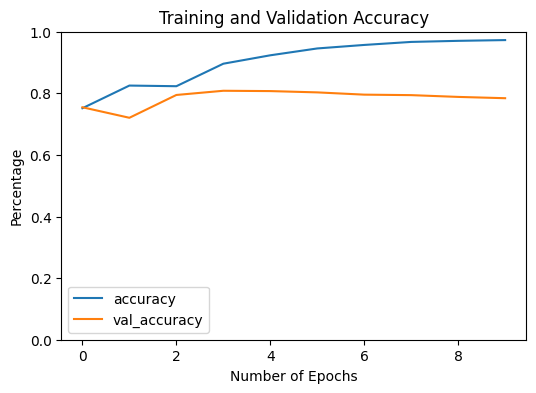

In [ ]:
plot_learning_curves(basic_model_results, [['accuracy', 'val_accuracy']])

We can see that this model is experiencing high validation loss. Let's introduce a second bidirectional LSTM layer and additional activation layers.

In [ ]:
def two_lstm_layers():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, weights=weights, input_length=sentence_length))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Dropout(0.5))   # Add regularization to ensure we aren't overfitting
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
two_lstm_layered_model = two_lstm_layers()
two_lstm_results = two_lstm_layered_model.fit(X_train, y_train, epochs = 8, batch_size = 32, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/8
179/179 [==============================] - 59s 282ms/step - loss: 0.4813 - accuracy: 0.7951 - val_loss: 0.4192 - val_accuracy: 0.8067
Epoch 2/8
179/179 [==============================] - 43s 242ms/step - loss: 0.3708 - accuracy: 0.8527 - val_loss: 0.4375 - val_accuracy: 0.8141
Epoch 3/8
179/179 [==============================] - 49s 272ms/step - loss: 0.2666 - accuracy: 0.8953 - val_loss: 0.5208 - val_accuracy: 0.7967
Epoch 4/8
179/179 [==============================] - 42s 235ms/step - loss: 0.1763 - accuracy: 0.9347 - val_loss: 0.5781 - val_accuracy: 0.8009
Epoch 5/8
179/179 [==============================] - 44s 248ms/step - loss: 0.1205 - accuracy: 0.9580 - val_loss: 0.6764 - val_accuracy: 0.7852
Epoch 6/8
179/179 [==============================] - 42s 235ms/step - loss: 0.0951 - accuracy: 0.9641 - val_loss: 0.7783 - val_accuracy: 0.7967
Epoch 7/8
179/179 [==============================] - 46s 258ms/step - loss: 0.0690 - accuracy: 0.9728 - val_loss: 0.9532 - val_accuracy:

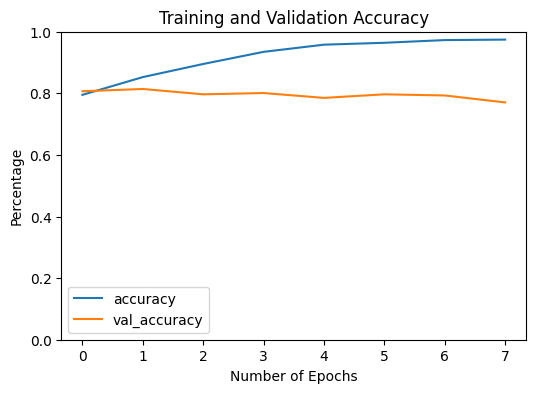

In [ ]:
plot_learning_curves(two_lstm_results, [['accuracy', 'val_accuracy']])